# Load previously selected features

The file being imported below was constructed in the last exploratory notebooks (2.1-rp-hcad-eda-appraised-value-perc-diff). These data have been cleaned, merged, and selected so we can start preparing it for modeling.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.definitions import ROOT_DIR
from src.data.utils import save_pickle

In [3]:
plt.style.use('seaborn-poster')

In [4]:
features_fn = ROOT_DIR / 'data/interim/2016/features.pickle'
assert features_fn.exists()

In [5]:
features = pd.read_pickle(features_fn)

In [6]:
features.sample(10)

,tot_appr_val,prior_tot_appr_val,im_sq_ft,perimeter,fixtures_total,room_half_bath,room_total,room_bedroom,room_rec,room_full_bath,story_height_index
acct,,,,,,,,,,,
1347180010051,275689.0,252419.0,2881.0,366.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0
1347180010030,253696.0,232580.0,2659.0,434.0,12.0,1.0,9.0,4.0,2.0,2.0,2.0
1347180030015,240964.0,244377.0,2272.0,362.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0
1347180030002,220623.0,208352.0,2213.0,208.0,13.0,0.0,10.0,4.0,3.0,3.0,2.0
1347180010052,283000.0,238989.0,3078.0,352.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0
1347180010043,220918.0,203258.0,1858.0,220.0,10.0,0.0,6.0,3.0,0.0,2.0,1.0
1347180010040,229971.0,210000.0,2094.0,218.0,10.0,0.0,7.0,3.0,1.0,2.0,1.0
1347180030025,248424.0,250759.0,2295.0,394.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0
1347180010032,287127.0,262771.0,3105.0,350.0,15.0,1.0,6.0,4.0,2.0,3.0,2.0


# Look at the target data distribution

In [7]:
from scipy import stats

<Figure size 576x576 with 0 Axes>

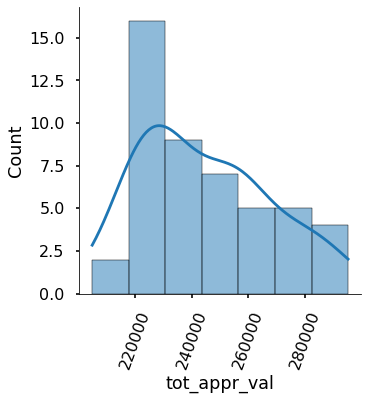

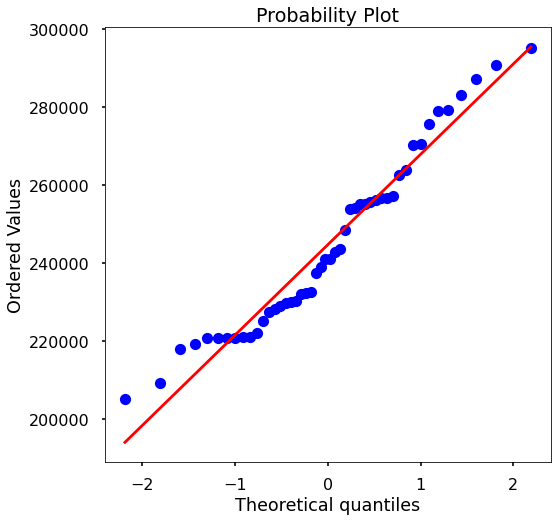

In [8]:
# sns.distplot(klein['appr_val_diff'], fit=stats.norm)
fig = plt.figure(figsize=(8, 8))
sns.displot(features['tot_appr_val'], kde=True)
plt.xticks(rotation=70)
fig = plt.figure(figsize=(8, 8))
res = stats.probplot(features['tot_appr_val'], plot=plt)

The target (total appraised value) is right skewed, however in the QQ plot it appears to be normal.

In [9]:
features.shape

(48, 11)

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 48 entries, 1347180010015 to 1347180030026
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tot_appr_val        48 non-null     float64
 1   prior_tot_appr_val  48 non-null     float64
 2   im_sq_ft            48 non-null     float64
 3   perimeter           48 non-null     float64
 4   fixtures_total      48 non-null     float32
 5   room_half_bath      48 non-null     float32
 6   room_total          48 non-null     float32
 7   room_bedroom        48 non-null     float32
 8   room_rec            48 non-null     float32
 9   room_full_bath      48 non-null     float32
 10  story_height_index  48 non-null     float32
dtypes: float32(7), float64(4)
memory usage: 3.2 KB


# Find neighbors

I'd like to see if my target house was reasonably appraised in 2016. If we plot it on the histogram of the `tot_appr_val` we can see it lands neat the high end.

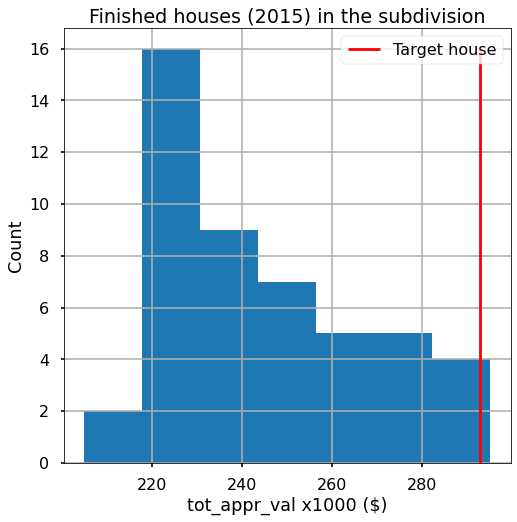

In [11]:
_ = plt.figure(figsize=(8,8))
_ = (features['tot_appr_val']/1000).hist(bins=7)
_ = plt.vlines(292707/1000, 0, 16, color='red', label='Target house')
_ = plt.title('Finished houses (2015) in the subdivision')
_ = plt.xlabel('tot_appr_val x1000 ($)')
_ = plt.ylabel('Count')
_ = plt.legend(loc='upper right')

But it could just be part of a larger distribution, so I'd like to group the properties by nearest neighbors (no pun intended!) to add this label as a new feature hoping to improve the target estimation.

In [12]:
from sklearn.cluster import KMeans

In [13]:
features.columns

Index(['tot_appr_val', 'prior_tot_appr_val', 'im_sq_ft', 'perimeter',
       'fixtures_total', 'room_half_bath', 'room_total', 'room_bedroom',
       'room_rec', 'room_full_bath', 'story_height_index'],
      dtype='object')

Let's drop the value columns to only group the houses by their characteristics (number of fixtures, areas).

In [14]:
no_values = features.drop(['tot_appr_val', 'prior_tot_appr_val'], axis=1).copy()

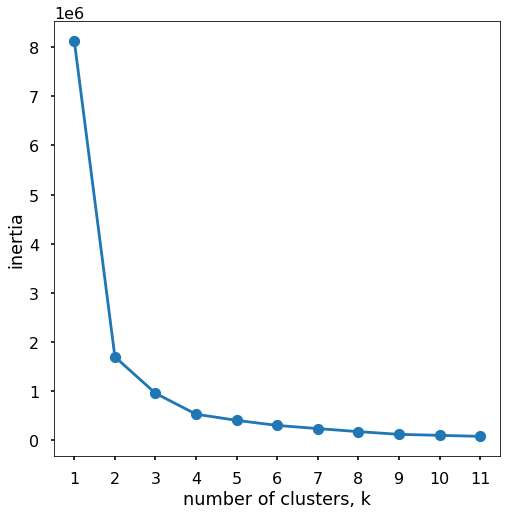

In [15]:
ks = range(1, 12)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(no_values)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize=(8, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Seems like 4 clusters is a good choice.

In [16]:
model = KMeans(n_clusters=4)

In [17]:
labels = model.fit_predict(no_values)

## TSNE
Now let's plot the selected labels using TSNE to find if these groups overlap or are separated.

In [18]:
from sklearn.manifold import TSNE

In [19]:
model = TSNE(learning_rate=100)

In [20]:
transformed = model.fit_transform(no_values)

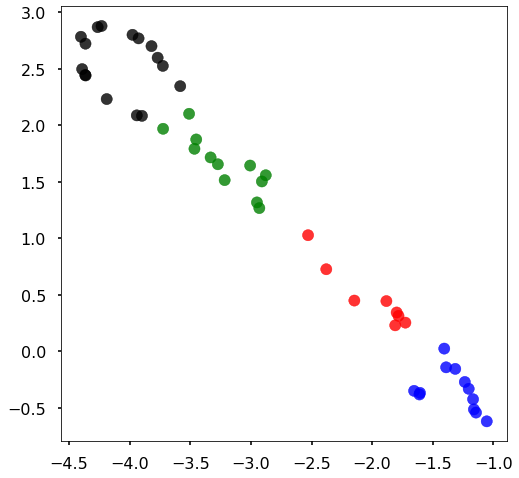

In [21]:
color_map = {0: 'black',
             1: 'red',
             2: 'blue',
             3: 'green'} 

colors = [color_map[x] for x in labels]

plt.figure(figsize=(8, 8))
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors, alpha=0.8)
plt.show()

Excellent! They are well separated indicating that these groups are meaningful.

Now let's add the labels found with K-meands back to the features dataframe.

In [22]:
features['kmeans_label'] = labels

In [23]:
features.head()

,tot_appr_val,prior_tot_appr_val,im_sq_ft,perimeter,fixtures_total,room_half_bath,room_total,room_bedroom,room_rec,room_full_bath,story_height_index,kmeans_label
acct,,,,,,,,,,,,
1347180010015,278939.0,255334.0,2954.0,374.0,15.0,1.0,8.0,4.0,1.0,3.0,2.0,2
1347180010017,227262.0,208763.0,2017.0,226.0,10.0,0.0,7.0,3.0,1.0,2.0,1.0,0
1347180010039,255481.0,234175.0,2689.0,362.0,12.0,1.0,8.0,4.0,2.0,2.0,2.0,1
1347180010042,255050.0,233809.0,2531.0,222.0,16.0,1.0,9.0,4.0,2.0,3.0,1.0,1
1347180010049,263704.0,267810.0,2697.0,430.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0,1


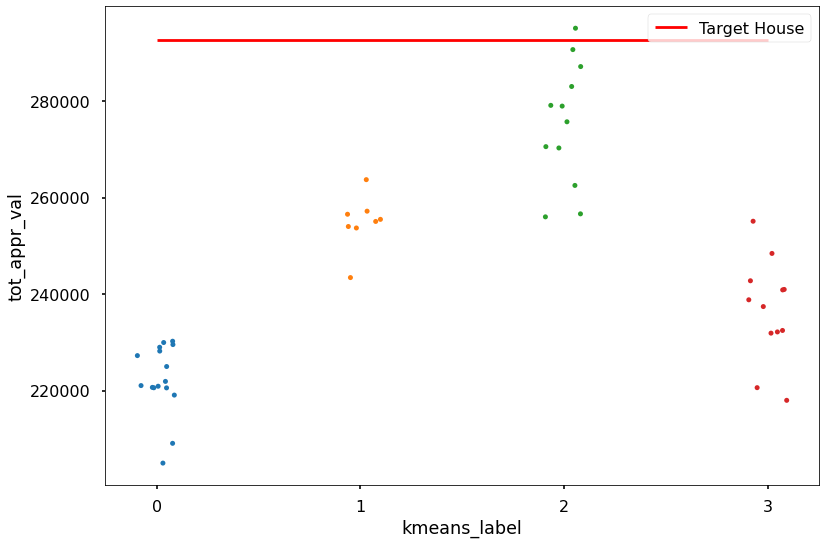

In [24]:
sns.stripplot(x='kmeans_label', y='tot_appr_val', data=features)
plt.hlines(292707, 0, 3, colors='red', label='Target House')
plt.legend(loc='upper right')

So it looks like the target house is part of a group, but even there lands on the high end of the appraised value.

# Prepare the data for modeling
Now that we have selected the features (areas and fixtures), built a new feature (K-means labels), verified that there are no null values, and selected the appropriate subset of the samples for the value modeling, we are ready to create the dummy features for the categorical variable (K-means labels), split the data, and scale it.

## Create dummy features for kmeans label

In [25]:
feat_dummy = pd.get_dummies(features, columns=['kmeans_label'], drop_first=True)

In [26]:
feat_dummy.head()

,tot_appr_val,prior_tot_appr_val,im_sq_ft,perimeter,fixtures_total,room_half_bath,room_total,room_bedroom,room_rec,room_full_bath,story_height_index,kmeans_label_1,kmeans_label_2,kmeans_label_3
acct,,,,,,,,,,,,,,
1347180010015,278939.0,255334.0,2954.0,374.0,15.0,1.0,8.0,4.0,1.0,3.0,2.0,0,1,0
1347180010017,227262.0,208763.0,2017.0,226.0,10.0,0.0,7.0,3.0,1.0,2.0,1.0,0,0,0
1347180010039,255481.0,234175.0,2689.0,362.0,12.0,1.0,8.0,4.0,2.0,2.0,2.0,1,0,0
1347180010042,255050.0,233809.0,2531.0,222.0,16.0,1.0,9.0,4.0,2.0,3.0,1.0,1,0,0
1347180010049,263704.0,267810.0,2697.0,430.0,15.0,1.0,9.0,4.0,2.0,3.0,2.0,1,0,0


## Split the data

In [29]:
from sklearn.model_selection import train_test_split

In [27]:
X = feat_dummy.drop(['tot_appr_val', 'prior_tot_appr_val'], axis=1)
y = feat_dummy['tot_appr_val']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Standardize data

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

StandardScaler()

In [38]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
y_scaler = StandardScaler()

In [42]:
y_scaler.fit(y_train.to_numpy().reshape(-1, 1))

StandardScaler()

In [45]:
y_train_scaled = y_scaler.transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))